In [1]:
import pandas as pd
import cmocean
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
from rectification_utils import *

import open3d as o3d
import laspy
import lazrs
import laszip

In [2]:
intrinsics = np.array([3040, # number of pixel columns
                       4056, # number of pixel rows
                       1503.0136, # U component of principal point
                       2163.4301, # V component of principal point
                       2330.4972, # U component of focal length
                       2334.0017, # V component of focal length
                       -0.3587, # radial distortion 
                       0.1388, # radial distortion
                       -0.0266, # radial distortion
                       -0.0046, # tangential distortion
                       0.0003 # tangential distortion
                       ])

In [3]:
extrinsics = np.array([712159.597863065, # camera x in world
                       33136.9994153273, # camera y in world
                       3.72446811607855, # camera elev in world
                       1.30039127961854, # azimuth
                       1.02781393967485, # tilt
                       -0.160877893129538 # roll/swing
                       ])

# Generate Grids

## Read in point cloud data

In [4]:
file_path = '/Users/ryan/Documents/image_processing/lidar/lidar_data/Job1051007_34077_04_88.laz'

las = laspy.read(file_path)


In [39]:
pts_mask = las.classification == 2 # land classification (1 is unclassified points)

xyz_t = np.vstack([las.x[pts_mask], las.y[pts_mask], las.z[pts_mask]])

# # Assume buildings are at least x feet above the ground
# building_height_threshold = 0
# building_mask = xyz_t[2, :] > building_height_threshold

# # Apply the mask to isolate potential building points
# building_xyz = xyz_t[:, building_mask]

# max_height_threshold = 200
# max_height_mask = building_xyz[2, :] < max_height_threshold
# building_xyz = building_xyz[:, max_height_mask]

# building_xyz_m = building_xyz * 0.3048 # meters

building_xyz_m = xyz_t * 0.3048 

In [137]:
point_cloud_df = pd.DataFrame(building_xyz_m.T, columns=['x', 'y', 'z'])

# max_x_extent = 712300
# min_x_extent = 712125
# max_y_extent = 33190
# min_y_extent = 33100

max_x_extent = 712230
min_x_extent = 712160
max_y_extent = 33170
min_y_extent = 33100

# Filter the DataFrame
filtered_df = point_cloud_df[
    (point_cloud_df['x'] >= min_x_extent) & (point_cloud_df['x'] <= max_x_extent) &
    (point_cloud_df['y'] >= min_y_extent) & (point_cloud_df['y'] <= max_y_extent)
]

x = filtered_df['x'].values
y = filtered_df['y'].values
z = filtered_df['z'].values

resolution = 0.01 # meters

In [138]:
pts_array = np.array([x, y, z])

print(pts_array.shape)

(3, 35549)


## Generate and plot grid

In [139]:
grid_x, grid_y, grid_z = gen_grid(min_x_extent, max_x_extent, min_y_extent, max_y_extent, resolution, pts_array)

Directory to store grids already exists: generated_grids


In [140]:
grid_x = grid_x.T
grid_y = grid_y.T
grid_z = grid_z.T

In [141]:
# Get the topo colormap from cmocean
cmap = cmocean.cm.topo

# Truncate the colormap to get only the above-land portion
# Assuming "above land" is the upper half of the colormap
above_land_cmap = LinearSegmentedColormap.from_list(
    'above_land_cmap', cmap(np.linspace(0.5, 1, 256))
)

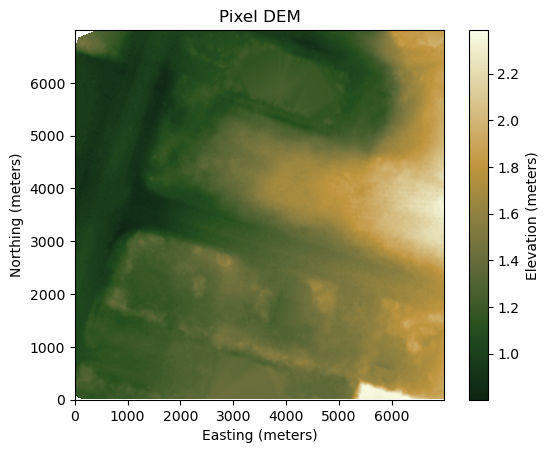

In [142]:
plt.imshow(grid_z, origin='lower', cmap=above_land_cmap)
plt.colorbar(label='Elevation (meters)')
plt.title('Pixel DEM')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')

# Save the figure before showing it
plt.savefig('pixel_DEM_1cm_res_CB_03.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

# Rectify

In [52]:
ir = mergeRectify('CAM_CB_03_20231008174225.jpg', intrinsics, extrinsics, grid_x, grid_y, grid_z)

/Users/ryan/Documents/image_processing/rectification_utils.py:243: RuntimeWarning: invalid value encountered in cast
  Ud = Ud.astype(int)
/Users/ryan/Documents/image_processing/rectification_utils.py:244: RuntimeWarning: invalid value encountered in cast
  Vd = Vd.astype(int)
/Users/ryan/Documents/image_processing/rectification_utils.py:247: RuntimeWarning: invalid value encountered in cast
  ir = np.array(ir, dtype=np.uint8)


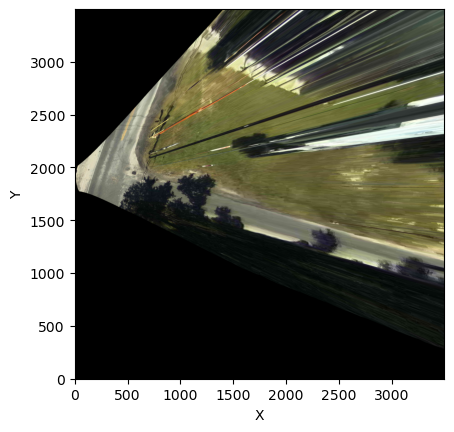

In [53]:
plt.imshow(ir)
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')

# plt.savefig('rectified_image.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

In [54]:
results = mergeRectifyFolder('/Users/ryan/Documents/image_processing/rectifications/CB_01_22_2023/CB_01222023_images', intrinsics, extrinsics, grid_x, grid_y, grid_z)

/Users/ryan/Documents/image_processing/rectification_utils.py:257: RuntimeWarning: invalid value encountered in cast
  Ud = np.round(Ud).astype(int)
/Users/ryan/Documents/image_processing/rectification_utils.py:258: RuntimeWarning: invalid value encountered in cast
  Vd = np.round(Vd).astype(int)
/Users/ryan/Documents/image_processing/rectification_utils.py:268: RuntimeWarning: invalid value encountered in cast
  ir = np.array(ir, dtype=np.uint8)


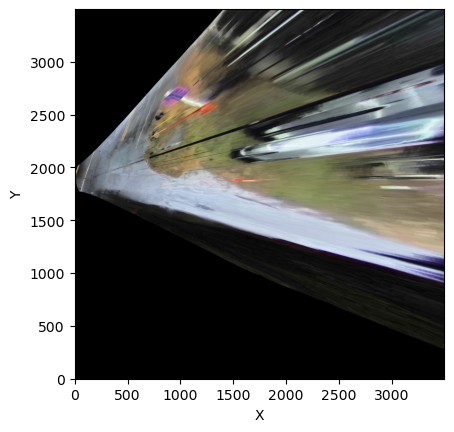

In [55]:
plt.imshow(results.iloc[1]['ir'])
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')

plt.savefig('rectified_image.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

In [56]:
# zarr_store_path = "rectifications/rect_arrays.zarr"
zarr_store_path = "/Users/ryan/Documents/image_processing/rectifications/CB_01_22_2023/Jan_22_2023_rectifications.zarr"
save_df_to_zarr(results, zarr_store_path)

<zarr.hierarchy.Group '/'>

In [57]:
from photo_utils import *

In [21]:
create_labels_from_preds("/Users/ryan/Documents/image_processing/rectifications/CB_01_22_2023/CB_01222023_preds",
                         "/Users/ryan/Documents/image_processing/rectifications/CB_01_22_2023/CB_01222023_labels")

Generating labels from predictions: 100%|██████████| 51/51 [00:11<00:00,  4.26it/s]


In [58]:
labels = mergeRectifyLabelsFolder('/Users/ryan/Documents/image_processing/rectifications/CB_01_22_2023/CB_01222023_labels', intrinsics, extrinsics, grid_x, grid_y, grid_z)
save_df_to_zarr(labels, zarr_store_path)

/Users/ryan/Documents/image_processing/rectification_utils.py:283: RuntimeWarning: invalid value encountered in cast
  Ud = np.round(Ud).astype(int)
/Users/ryan/Documents/image_processing/rectification_utils.py:284: RuntimeWarning: invalid value encountered in cast
  Vd = np.round(Vd).astype(int)
/Users/ryan/Documents/image_processing/rectification_utils.py:293: RuntimeWarning: invalid value encountered in cast
  ir = np.array(ir, dtype=np.uint8)


<zarr.hierarchy.Group '/'>

In [59]:
# Open the Zarr store in read mode
store = zarr.open_group(zarr_store_path, mode='r')

# Load the specific array using its name
ir_array = store['CAM_CB_03_20230122121225_predseg_labels_rectified'][:]

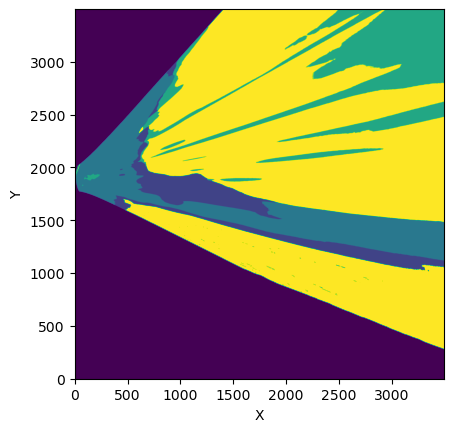

In [60]:
plt.imshow(ir_array)
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')

plt.savefig('rectified_labels_image.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

## Depth Mapping

In [243]:
zarr_store_path = '/Users/ryan/Documents/image_processing/rectifications/CB_10_02_2023/rect_arrays.zarr'

# Open the Zarr store in read mode
store = zarr.open_group(zarr_store_path, mode='r')

# Load the specific array using its name
ir_array = store['CAM_CB_03_20231002150626_predseg_labels_rectified'][:]

In [244]:
ir_array.shape

(7000, 7000, 1)

In [245]:
grid_z.shape

(7000, 7000)

### Original Maximum Elevation Depth Mapping Approach

In [246]:
labels_squeezed = ir_array.squeeze()

mask = (labels_squeezed == 1)

masked_elevations = np.where(mask, grid_z, np.nan)  # Use np.nan or another value for masked entries


In [247]:
masked_elevations.shape

(7000, 7000)

In [248]:
# max_elevation = np.nanmax(masked_elevations)
# max_indices = np.unravel_index(np.nanargmax(masked_elevations), masked_elevations.shape)
# depth_map = np.abs(masked_elevations - max_elevation)

In [249]:
# Step 1: Replace NaNs with a value that will not interfere with contour detection
arr_with_zeros = np.nan_to_num(masked_elevations, nan=0)

# Step 2: Detect contours
contours = find_contours(arr_with_zeros, level=0.5)

# Step 3: Convert contour coordinates to integer indices
contour_pixels = []
for contour in contours:
    for point in contour:
        y, x = np.round(point).astype(int)
        if 0 <= x < masked_elevations.shape[1] and 0 <= y < masked_elevations.shape[0]:  # Ensure indices are within bounds
            contour_pixels.append((x, y))

# Convert list to NumPy array for easier manipulation
contour_pixels = np.array(contour_pixels)

# Create a mask to identify valid pixels
valid_mask = ~np.isnan(masked_elevations)

# Get the coordinates of valid pixels
valid_coords = np.array(np.nonzero(valid_mask)).T

# Get the values at valid coordinates
valid_values = masked_elevations[valid_mask]

# Build a KD-tree from valid coordinates
tree = cKDTree(valid_coords)

# Find the nearest valid pixel for each contour pixel
distances, indices = tree.query(contour_pixels)

# Get the corresponding values
contour_values = valid_values[indices]
max_elevation = np.nanmedian(contour_values)
depth_map = masked_elevations - max_elevation
depth_map[depth_map > 0] = 0
depth_map = np.abs(depth_map)

In [250]:
# Open the Zarr store in read mode
store = zarr.open_group(zarr_store_path, mode='r')

# Load the specific array using its name
background = store['CAM_CB_03_20231002150626_rectified'][:]
grayscale_image = np.dot(background[...,:3], [0.2989, 0.5870, 0.1140])


/var/folders/kr/t52nlmpn6n38qycgmd0q087c0000gn/T/ipykernel_7225/1649432150.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks / 100)  # Divide by 100 to convert cm to meters
/var/folders/kr/t52nlmpn6n38qycgmd0q087c0000gn/T/ipykernel_7225/1649432150.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks / 100)  # Divide by 100 to convert cm to meters


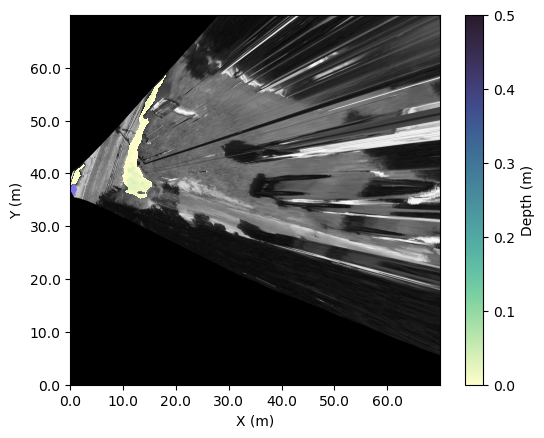

In [292]:
# Plot the image
plt.imshow(grayscale_image, cmap='gray')  # Assuming ir_array is your grayscale image

# Overlay the depth map
im = plt.imshow(depth_map, cmap=cmocean.cm.deep, vmin=0, vmax=0.5)  # Adjust alpha for transparency
# plt.scatter(virtual_sensor_locs[0][0], virtual_sensor_locs[0][1], color=sensor_1_color, s=25, marker='v')
# plt.scatter(virtual_sensor_locs[1][0], virtual_sensor_locs[1][1], color=sensor_2_color, s=25, marker='s')
plt.scatter(virtual_sensor_locs[2][0], virtual_sensor_locs[2][1], color=sensor_3_color, s=25, marker='d')
# plt.scatter(max_indices[1], max_indices[0], c='red', s=10, marker='o')

# Add a colorbar for the depth map
cbar = plt.colorbar(im, label='Depth')
cbar.set_label('Depth (m)')

ax = plt.gca()  # Get the current axis
x_ticks = ax.get_xticks()  # Get current x-axis ticks
y_ticks = ax.get_yticks()  # Get current y-axis ticks

# Update tick labels to convert from cm to meters
ax.set_xticklabels(x_ticks / 100)  # Divide by 100 to convert cm to meters
ax.set_yticklabels(y_ticks / 100)  # Divide by 100 to convert cm to meters

plt.gca().invert_yaxis()
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

# Save the figure
plt.savefig('rectified_image_with_depth.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

# Show the plot
plt.show()

In [297]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example array
array = grayscale_image

# Function to handle zoom using scroll events
def zoom_factory(ax, base_scale=2.):
    def zoom_fun(event):
        # get the current x and y limits
        cur_xlim = ax.get_xlim()
        cur_ylim = ax.get_ylim()

        # Get the current position of the mouse
        xdata = event.xdata
        ydata = event.ydata
        if xdata is None or ydata is None:
            return  # if mouse is out of the plot

        # Calculate the new limits
        scale_factor = 1 / base_scale if event.button == 'up' else base_scale

        new_width = (cur_xlim[1] - cur_xlim[0]) * scale_factor
        new_height = (cur_ylim[1] - cur_ylim[0]) * scale_factor

        relx = (cur_xlim[1] - cur_xlim[0]) / 2
        rely = (cur_ylim[1] - cur_ylim[0]) / 2

        ax.set_xlim([xdata - relx * scale_factor, xdata + relx * scale_factor])
        ax.set_ylim([ydata - rely * scale_factor, ydata + rely * scale_factor])
        ax.figure.canvas.draw_idle()  # force a redraw

    fig.canvas.mpl_connect('scroll_event', zoom_fun)
    return zoom_fun

# Display the array
fig, ax = plt.subplots()
cax = ax.imshow(array, cmap='gray')
plt.colorbar(cax)

# Enable zooming functionality with scroll wheel
zoom_factory(ax)

# Let user pick points
plt.title('Click on points, close the window when done')
clicked_points = plt.ginput(n=-1, timeout=0)  # -1 allows unlimited points, 0 means no timeout

# Convert the clicked points to pixel indices
pixel_indices = [(int(round(y)), int(round(x))) for x, y in clicked_points]

# Display the clicked points
print("Pixel indices:", pixel_indices)

# Save the indices to a file (e.g., CSV)
df = pd.DataFrame(pixel_indices, columns=['Row', 'Column'])
df.to_csv('selected_pixel_indices.csv', index=False)

# Show the plot
plt.show()


Pixel indices: [(6268, -894), (3547, 86)]


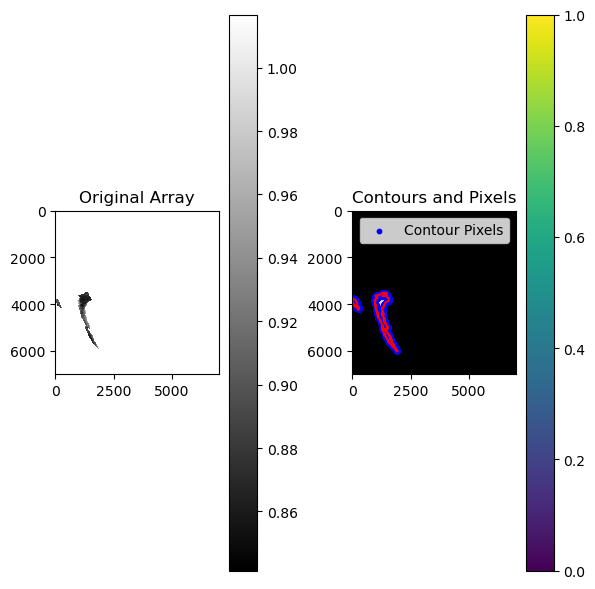

In [269]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from scipy.spatial import cKDTree

# Sample array with values and NaNs
arr = masked_elevations

# Step 1: Replace NaNs with a value that will not interfere with contour detection
arr_with_zeros = np.nan_to_num(arr, nan=0)

# Step 2: Detect contours
contours = find_contours(arr_with_zeros, level=0.5)

# Step 3: Convert contour coordinates to integer indices
contour_pixels = []
for contour in contours:
    for point in contour:
        y, x = np.round(point).astype(int)
        if 0 <= x < arr.shape[1] and 0 <= y < arr.shape[0]:  # Ensure indices are within bounds
            contour_pixels.append((x, y))

# Convert list to NumPy array for easier manipulation
contour_pixels = np.array(contour_pixels)

# Step 4: Reference pixel values at contour locations
# contour_values = arr[contour_pixels[:, 1], contour_pixels[:, 0]]

# Create a mask to identify valid pixels
valid_mask = ~np.isnan(arr)

# Get the coordinates of valid pixels
valid_coords = np.array(np.nonzero(valid_mask)).T

# Get the values at valid coordinates
valid_values = arr[valid_mask]

# Build a KD-tree from valid coordinates
tree = cKDTree(valid_coords)

# Find the nearest valid pixel for each contour pixel
distances, indices = tree.query(contour_pixels)

# Get the corresponding values
contour_values = valid_values[indices]

# print(contour_values)

# Plotting the result
plt.figure(figsize=(6, 6))

# Plot the original array (with NaNs masked out)
plt.subplot(1, 2, 1)
plt.imshow(arr, cmap='gray', interpolation='none')
plt.title("Original Array")
plt.colorbar()

# Plot the contours on top of the array
plt.subplot(1, 2, 2)
plt.imshow(arr_with_zeros, cmap='gray', interpolation='none')
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], color='red')  # Note: contour[:, 0] is y, contour[:, 1] is x
plt.scatter(contour_pixels[:, 0], contour_pixels[:, 1], color='blue', s=10, label='Contour Pixels')
plt.title("Contours and Pixels")
plt.colorbar()
plt.legend()

plt.tight_layout()
plt.show()

# Print contour pixel values
# for (x, y), value in zip(contour_pixels, contour_values):
#     print(f"Pixel ({x}, {y}) has value: {value}")


/var/folders/kr/t52nlmpn6n38qycgmd0q087c0000gn/T/ipykernel_7225/1070529602.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks / 100)  # Divide by 100 to convert cm to meters
/var/folders/kr/t52nlmpn6n38qycgmd0q087c0000gn/T/ipykernel_7225/1070529602.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks / 100)  # Divide by 100 to convert cm to meters


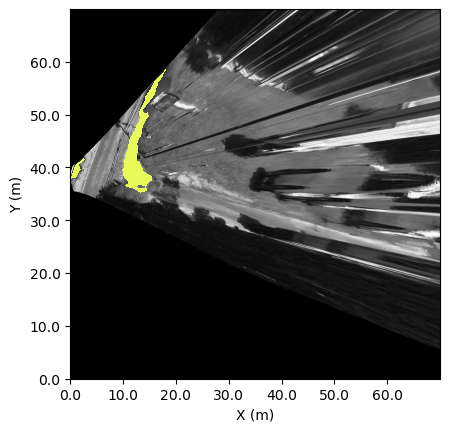

In [288]:
# Plot the image
plt.imshow(grayscale_image, cmap='gray')  # Assuming ir_array is your grayscale image

# Overlay the depth map
# im = plt.imshow(depth_map, cmap=cmocean.cm.deep, vmin=0, vmax=0.5)  # Adjust alpha for transparency
# plt.scatter(virtual_sensor_locs[0][0], virtual_sensor_locs[0][1], color=sensor_1_color, s=25, marker='v')
# plt.scatter(virtual_sensor_locs[1][0], virtual_sensor_locs[1][1], color=sensor_2_color, s=25, marker='s')
# plt.scatter(virtual_sensor_locs[2][0], virtual_sensor_locs[2][1], color=sensor_3_color, s=25, marker='d')
# plt.scatter(max_indices[1], max_indices[0], c='red', s=10, marker='o')

im = plt.imshow(masked_elevations, cmap=cmocean.cm.thermal, vmin=0, vmax=0.5)  # Adjust alpha for transparency
# for contour in contours:
#     plt.plot(contour[:, 1], contour[:, 0], color='red')  # Note: contour[:, 0] is y, contour[:, 1] is x
# plt.scatter(contour_pixels[:, 0], contour_pixels[:, 1], color='red', s=1, label='Edge Pixels')

# Add a colorbar for the depth map
# cbar = plt.colorbar(im, label='Depth')
# cbar.set_label('Depth (m)')

ax = plt.gca()  # Get the current axis
x_ticks = ax.get_xticks()  # Get current x-axis ticks
y_ticks = ax.get_yticks()  # Get current y-axis ticks

# Update tick labels to convert from cm to meters
ax.set_xticklabels(x_ticks / 100)  # Divide by 100 to convert cm to meters
ax.set_yticklabels(y_ticks / 100)  # Divide by 100 to convert cm to meters

plt.gca().invert_yaxis()
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
# plt.legend()

# Save the figure
plt.savefig('segmented_shape.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

# Show the plot
plt.show()

### Plot Orig Image, Overlay, and Depth Map

In [103]:
orig_image = cv2.imread('/Users/ryan/Documents/image_processing/CB_03_modeled_test_set/master_modeled_test_sets/CAM_CB_03_20231002164825.jpg')
orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
image_overlay = cv2.imread('/Users/ryan/Documents/image_processing/CB_03_modeled_test_set/segmap_overlays/segmap_overlay_CAM_CB_03_20231002164825.jpg')
image_overlay = cv2.cvtColor(image_overlay, cv2.COLOR_BGR2RGB)

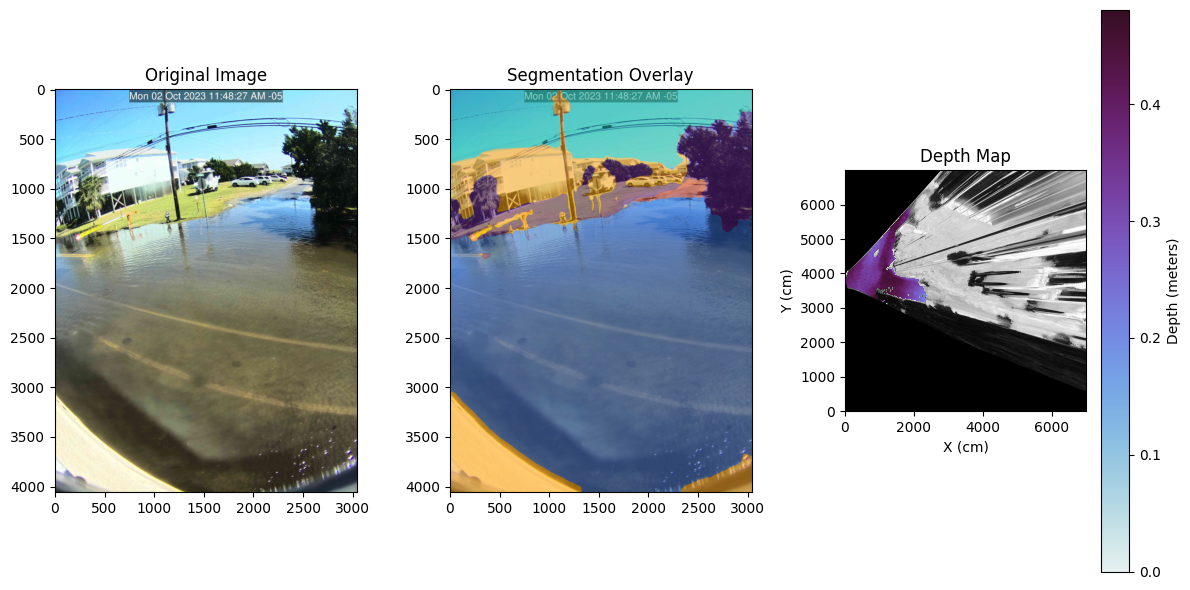

In [104]:
# Create a figure and a set of subplots (2 columns, 1 row)
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# Plot the grayscale image
axs[0].imshow(orig_image)
axs[0].set_title('Original Image')

axs[1].imshow(image_overlay)
axs[1].set_title('Segmentation Overlay')

# Plot the depth map
axs[2].imshow(grayscale_image, cmap='gray')
depth_img = axs[2].imshow(depth_map, cmap=cmocean.cm.dense)
axs[2].set_title('Depth Map')
axs[2].invert_yaxis()  # Invert y-axis to match image orientation
axs[2].set_xlabel('X (cm)')
axs[2].set_ylabel('Y (cm)')

# Add a colorbar for the depth map
cbar = plt.colorbar(depth_img, ax=axs[2], label='Depth (meters)')
cbar.set_label('Depth (meters)')

# Adjust layout
plt.tight_layout()

plt.savefig('image_rectification_steps.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

# Show the plot
plt.show()


### Roadway Masking

In [14]:
road_mask_rect = mergeRectifyLabels('roadway_mask.png', intrinsics, extrinsics, grid_x, grid_y, grid_z)

/var/folders/kr/t52nlmpn6n38qycgmd0q087c0000gn/T/ipykernel_33855/1376719749.py:12: RuntimeWarning: invalid value encountered in cast
  Ud = Ud.astype(int)
/var/folders/kr/t52nlmpn6n38qycgmd0q087c0000gn/T/ipykernel_33855/1376719749.py:13: RuntimeWarning: invalid value encountered in cast
  Vd = Vd.astype(int)
/var/folders/kr/t52nlmpn6n38qycgmd0q087c0000gn/T/ipykernel_33855/1376719749.py:16: RuntimeWarning: invalid value encountered in cast
  ir = np.array(ir, dtype=np.uint8)


In [15]:
roadway_mask = np.array(road_mask_rect) > 0

In [ ]:
masked_image = np.where(roadway_mask, ir_array, 0)

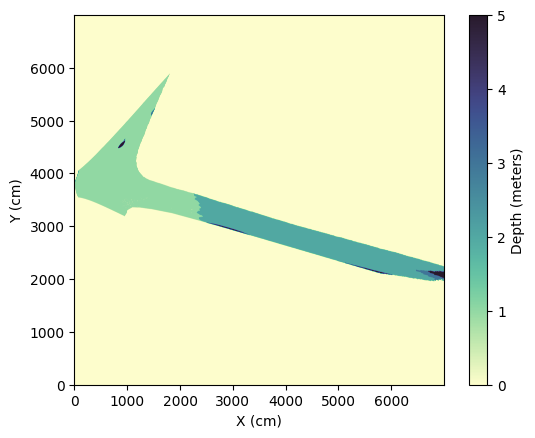

In [26]:
# Plot the image
# plt.imshow(grayscale_image, cmap='gray')  # Assuming ir_array is your grayscale image

# Overlay the depth map
im = plt.imshow(masked_image, cmap=cmocean.cm.deep)  # Adjust alpha for transparency
# plt.scatter(virtual_sensor_locs[0][0], virtual_sensor_locs[0][1], color=sensor_1_color, s=50, marker='v')
# plt.scatter(virtual_sensor_locs[1][0], virtual_sensor_locs[1][1], color=sensor_2_color, s=50, marker='s')
# plt.scatter(virtual_sensor_locs[2][0], virtual_sensor_locs[2][1], color=sensor_3_color, s=50, marker='d')
# plt.scatter(max_indices[1], max_indices[0], c='red', s=10, marker='o')

# Add a colorbar for the depth map
cbar = plt.colorbar(im, label='Depth')
cbar.set_label('Depth (meters)')

plt.gca().invert_yaxis()
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')

# Save the figure
# plt.savefig('rectified_image_with_depth.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

# Show the plot
plt.show()

In [34]:
labels_squeezed = masked_image.squeeze()

mask = (labels_squeezed == 1)

masked_elevations = np.where(mask, grid_z, np.nan)  # Use np.nan or another value for masked entries


In [35]:
max_elevation = np.nanmax(masked_elevations)
max_indices = np.unravel_index(np.nanargmax(masked_elevations), masked_elevations.shape)
depth_map = np.abs(masked_elevations - max_elevation)

In [36]:
# Open the Zarr store in read mode
store = zarr.open_group("rectifications/rect_arrays.zarr", mode='r')

# Load the specific array using its name
ir_array = store['CAM_CB_03_20231002164825_rectified'][:]

grayscale_image = np.dot(ir_array[...,:3], [0.2989, 0.5870, 0.1140])


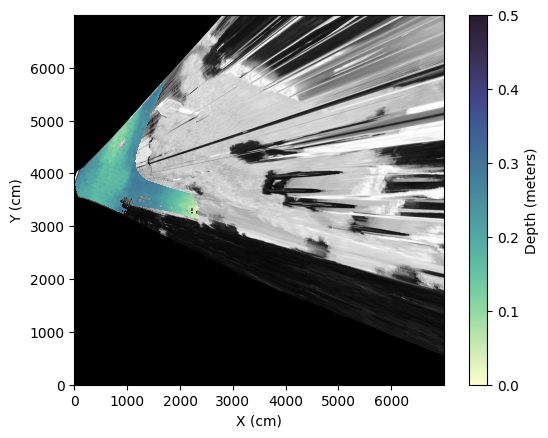

In [37]:
# Plot the image
plt.imshow(grayscale_image, cmap='gray')  # Assuming ir_array is your grayscale image

# Overlay the depth map
im = plt.imshow(depth_map, cmap=cmocean.cm.deep, vmin=0, vmax=0.5)  # Adjust alpha for transparency
# plt.scatter(virtual_sensor_locs[0][0], virtual_sensor_locs[0][1], color=sensor_1_color, s=50, marker='v')
# plt.scatter(virtual_sensor_locs[1][0], virtual_sensor_locs[1][1], color=sensor_2_color, s=50, marker='s')
# plt.scatter(virtual_sensor_locs[2][0], virtual_sensor_locs[2][1], color=sensor_3_color, s=50, marker='d')
# plt.scatter(max_indices[1], max_indices[0], c='red', s=10, marker='o')

# Add a colorbar for the depth map
cbar = plt.colorbar(im, label='Depth')
cbar.set_label('Depth (meters)')

plt.gca().invert_yaxis()
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')

# Save the figure
# plt.savefig('rectified_image_with_depth.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

# Show the plot
plt.show()

In [33]:
np.nanmax(depth_map)

0.4806863854227347

In [38]:
np.nanmax(depth_map)

0.3130459321713469

In [ ]:
def generate_masked_label_rects(zarr_store_path, roadway_mask):
    
    masked_rects = []
    
    # Open the Zarr store in read mode
    store = zarr.open_group(zarr_store_path, mode='r')

    # Iterate through all arrays in the store
    for array_name in store:
        # Check if 'labels' is in the array's name
        if 'labels' in array_name:
            # Load the specific array
            array = store[array_name][:]

            masked_image = roadway_mask * array

            # Append the image name and ir array to the list
            masked_rects.append({'image_name': array_name + '_masked', 'masked_array': masked_image})

    results = pd.DataFrame(masked_rects)

    return results

In [ ]:
def generate_depth_maps_from_folder_masked(zarr_store_path, grid_z, rectified_mask):
    
    depth_data = []
    
    # Open the Zarr store in read mode
    store = zarr.open_group(zarr_store_path, mode='r')

    roadway_mask = np.array(rectified_mask) > 0

    # Iterate through all arrays in the store
    for array_name in store:
        # Check if 'labels' is in the array's name
        if 'labels' in array_name:
            # Load the specific array
            array = store[array_name][:]

            masked_image = np.where(roadway_mask, array, 0)

            labels_squeezed = masked_image.squeeze()

            mask = (labels_squeezed == 1)
            masked_elevations = np.where(mask, grid_z, np.nan)

            max_elevation = np.nanmax(masked_elevations)
            depth_map = np.abs(masked_elevations - max_elevation)

            # Append the image name and ir array to the list
            depth_data.append({'image_name': array_name + '_depth_map_masked', 'depth_map': depth_map})

    results = pd.DataFrame(depth_data)

    return results

In [ ]:
masked_rects = generate_masked_label_rects(zarr_store_path, roadway_mask)

In [ ]:
depth_maps_masked = generate_depth_maps_from_folder_masked(zarr_store_path, grid_z, road_mask_rect)

## Generate Depth Maps for Multiple Images

In [4]:
zarr_store_path = 'rectifications/rect_arrays.zarr'

In [34]:
def generate_depth_maps_from_folder(zarr_store_path, grid_z):
    
    depth_data = []
    
    # Open the Zarr store in read mode
    store = zarr.open_group(zarr_store_path, mode='r')

    # Iterate through all arrays in the store
    for array_name in store:
        # Check if 'labels' is in the array's name
        if 'labels' in array_name:
            # Load the specific array
            array = store[array_name][:]

            labels_squeezed = array.squeeze()

            mask = (labels_squeezed == 1)
            masked_elevations = np.where(mask, grid_z, np.nan)

            # max_elevation = np.nanmax(masked_elevations)
            # depth_map = np.abs(masked_elevations - max_elevation)

            max_elevation = np.nanpercentile(masked_elevations, 95)
            depth_map = masked_elevations - max_elevation
            depth_map[depth_map > 0] = 0
            depth_map = np.abs(depth_map)

            # Append the image name and ir array to the list
            depth_data.append({'image_name': array_name + '_depth_map_95th', 'depth_map': depth_map})

    results = pd.DataFrame(depth_data)

    return results

In [166]:
def generate_depth_maps_from_folder(zarr_store_path, grid_z):
    
    depth_data = []
    
    # Open the Zarr store in read mode
    store = zarr.open_group(zarr_store_path, mode='r')

    # Iterate through all arrays in the store
    for array_name in store:
        # Check if 'labels' is in the array's name
        if 'labels' in array_name and 'depth' not in array_name:
            # Load the specific array
            array = store[array_name][:]
            print(array_name)

            labels_squeezed = array.squeeze()

            mask = (labels_squeezed == 1)
            masked_elevations = np.where(mask, grid_z, np.nan)

            # max_elevation = np.nanmax(masked_elevations)
            # depth_map = np.abs(masked_elevations - max_elevation)
            # max_elevation = np.nanpercentile(masked_elevations, 95)
            # depth_map = masked_elevations - max_elevation
            # depth_map[depth_map > 0] = 0
            # depth_map = np.abs(depth_map)

            # Step 1: Replace NaNs with a value that will not interfere with contour detection
            arr_with_zeros = np.nan_to_num(masked_elevations, nan=0)

            # Step 2: Detect contours
            contours = find_contours(arr_with_zeros, level=0.5)
            print(len(contours))

            # Step 3: Convert contour coordinates to integer indices
            contour_pixels = []
            for contour in contours:
                for point in contour:
                    y, x = np.round(point).astype(int)
                    if 0 <= x < masked_elevations.shape[1] and 0 <= y < masked_elevations.shape[0]:  # Ensure indices are within bounds
                        contour_pixels.append((x, y))

            # Convert list to NumPy array for easier manipulation
            contour_pixels = np.array(contour_pixels)

            # Create a mask to identify valid pixels
            valid_mask = ~np.isnan(masked_elevations)

            # Get the coordinates of valid pixels
            valid_coords = np.array(np.nonzero(valid_mask)).T

            # Get the values at valid coordinates
            valid_values = masked_elevations[valid_mask]

            # Build a KD-tree from valid coordinates
            tree = cKDTree(valid_coords)

            # Find the nearest valid pixel for each contour pixel
            distances, indices = tree.query(contour_pixels)

            # Get the corresponding values
            contour_values = valid_values[indices]
            max_elevation = np.nanmedian(contour_values)
            depth_map = masked_elevations - max_elevation
            depth_map[depth_map > 0] = 0
            depth_map = np.abs(depth_map)


            # Append the image name and ir array to the list
            depth_data.append({'image_name': array_name + '_depth_map_median_edge', 'depth_map': depth_map})

    results = pd.DataFrame(depth_data)

    return results

In [167]:
median_depth_maps = generate_depth_maps_from_folder(zarr_store_path, grid_z)

CAM_CB_03_20231002140025_predseg_labels_rectified
206
CAM_CB_03_20231002140625_predseg_labels_rectified
127
CAM_CB_03_20231002141225_predseg_labels_rectified
157
CAM_CB_03_20231002141825_predseg_labels_rectified
202
CAM_CB_03_20231002142425_predseg_labels_rectified
15
CAM_CB_03_20231002143025_predseg_labels_rectified
166
CAM_CB_03_20231002143625_predseg_labels_rectified
139
CAM_CB_03_20231002144226_predseg_labels_rectified
143
CAM_CB_03_20231002144825_predseg_labels_rectified
152
CAM_CB_03_20231002145425_predseg_labels_rectified
167
CAM_CB_03_20231002150025_predseg_labels_rectified
226
CAM_CB_03_20231002150626_predseg_labels_rectified
149
CAM_CB_03_20231002151225_predseg_labels_rectified
320
CAM_CB_03_20231002151825_predseg_labels_rectified
484
CAM_CB_03_20231002152425_predseg_labels_rectified
1232
CAM_CB_03_20231002153025_predseg_labels_rectified
1465
CAM_CB_03_20231002153625_predseg_labels_rectified
294
CAM_CB_03_20231002154225_predseg_labels_rectified
627
CAM_CB_03_20231002154825_pr

In [168]:
save_df_to_zarr(median_depth_maps, zarr_store_path, depth_map=True)

<zarr.hierarchy.Group '/'>

### New Attempt at Using only edge pixels

In [71]:
# Open the Zarr store in read mode
store = zarr.open_group(zarr_store_path, mode='r')

# Load the specific array using its name
ir_array = store['CAM_CB_03_20230122121225_predseg_labels_rectified'][:]


In [73]:
labels_squeezed = ir_array.squeeze()

mask = (labels_squeezed == 1)
masked_elevations = np.where(mask, grid_z, np.nan)

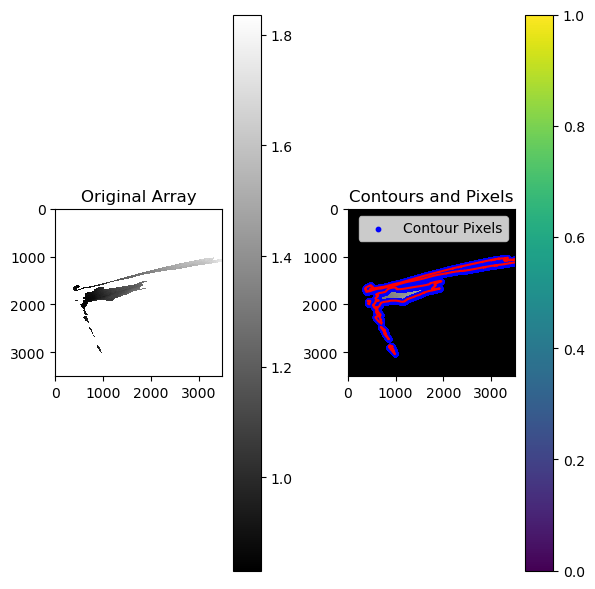

Pixel (3339, 1033) has value: 1.033964741418414
Pixel (3338, 1032) has value: 1.033964741418414
Pixel (3338, 1031) has value: 1.033964741418414
Pixel (3338, 1030) has value: 1.033964741418414
Pixel (3338, 1029) has value: 1.033964741418414
Pixel (3338, 1028) has value: 1.033964741418414
Pixel (3338, 1027) has value: 1.033964741418414
Pixel (3338, 1026) has value: 1.033964741418414
Pixel (3338, 1025) has value: 1.033964741418414
Pixel (3338, 1024) has value: 1.033964741418414
Pixel (3339, 1023) has value: 1.033964741418414
Pixel (3339, 1023) has value: 1.033964741418414
Pixel (3339, 1022) has value: 1.033964741418414
Pixel (3340, 1021) has value: 1.033964741418414
Pixel (3341, 1021) has value: 1.033964741418414
Pixel (3341, 1021) has value: 1.033964741418414
Pixel (3342, 1020) has value: 1.033964741418414
Pixel (3343, 1020) has value: 1.033964741418414
Pixel (3344, 1020) has value: 1.033964741418414
Pixel (3345, 1020) has value: 1.033964741418414
Pixel (3345, 1020) has value: 1.03396474

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from scipy.spatial import cKDTree

# Sample array with values and NaNs
arr = masked_elevations

# Step 1: Replace NaNs with a value that will not interfere with contour detection
arr_with_zeros = np.nan_to_num(arr, nan=0)

# Step 2: Detect contours
contours = find_contours(arr_with_zeros, level=0.5)

# Step 3: Convert contour coordinates to integer indices
contour_pixels = []
for contour in contours:
    for point in contour:
        y, x = np.round(point).astype(int)
        if 0 <= x < arr.shape[1] and 0 <= y < arr.shape[0]:  # Ensure indices are within bounds
            contour_pixels.append((x, y))

# Convert list to NumPy array for easier manipulation
contour_pixels = np.array(contour_pixels)

# Step 4: Reference pixel values at contour locations
# contour_values = arr[contour_pixels[:, 1], contour_pixels[:, 0]]

# Create a mask to identify valid pixels
valid_mask = ~np.isnan(arr)

# Get the coordinates of valid pixels
valid_coords = np.array(np.nonzero(valid_mask)).T

# Get the values at valid coordinates
valid_values = arr[valid_mask]

# Build a KD-tree from valid coordinates
tree = cKDTree(valid_coords)

# Find the nearest valid pixel for each contour pixel
distances, indices = tree.query(contour_pixels)

# Get the corresponding values
contour_values = valid_values[indices]

# print(contour_values)

# Plotting the result
plt.figure(figsize=(6, 6))

# Plot the original array (with NaNs masked out)
plt.subplot(1, 2, 1)
plt.imshow(arr, cmap='gray', interpolation='none')
plt.title("Original Array")
plt.colorbar()

# Plot the contours on top of the array
plt.subplot(1, 2, 2)
plt.imshow(arr_with_zeros, cmap='gray', interpolation='none')
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], color='red')  # Note: contour[:, 0] is y, contour[:, 1] is x
plt.scatter(contour_pixels[:, 0], contour_pixels[:, 1], color='blue', s=10, label='Contour Pixels')
plt.title("Contours and Pixels")
plt.colorbar()
plt.legend()

plt.tight_layout()
plt.show()

# Print contour pixel values
for (x, y), value in zip(contour_pixels, contour_values):
    print(f"Pixel ({x}, {y}) has value: {value}")


In [128]:
contour_pixels

array([[3339, 1033],
       [3338, 1032],
       [3338, 1031],
       ...,
       [ 984, 3029],
       [ 985, 3030],
       [ 984, 3031]])

In [129]:
contour_values.size

17144

In [130]:
num_nans = np.sum(np.isnan(contour_values))

print(f"Number of NaNs: {num_nans}")

Number of NaNs: 0


### Plot Depth Maps

In [169]:
def plot_depth_maps(zarr_store_path, grid_z, plotting_folder, depth_min=None, depth_max=None):
    
    if not os.path.exists(plotting_folder):
        os.makedirs(plotting_folder)
        print(f'Directory to store grids created: {plotting_folder}')
    else:
        print(f'Directory to store grids already exists: {plotting_folder}')

    # Open the Zarr store in read mode
    store = zarr.open_group(zarr_store_path, mode='r')

    pattern = re.compile(r'(?P<cam_id>CAM_[A-Z]{2}_\d{2})_(?P<timestamp>\d{14})_rectified')

    for array_name in store.keys():
        match = pattern.match(array_name)
        if match:
            cam_id = match.group('cam_id')
            timestamp = match.group('timestamp')
            
            # Load the rectified image array
            rectified_image = store[f"{cam_id}_{timestamp}_rectified"]
            grayscale_image = np.dot(rectified_image[...,:3], [0.2989, 0.5870, 0.1140])
            
            # Load the depth map array
            depth_map_name = f"{cam_id}_{timestamp}_predseg_labels_rectified_depth_map_median_edge_rectified"
            depth_map = store[depth_map_name]

            max_elev_point_indices = np.unravel_index(np.nanargmin(depth_map), depth_map.shape)

            # Plot the image
            plt.imshow(grayscale_image, cmap='gray')  # Assuming ir_array is your grayscale image

            # Overlay the depth map
            im = plt.imshow(depth_map, cmap=cmocean.cm.deep, vmin=depth_min, vmax=depth_max)  # Adjust alpha for transparency
            # print(f"Vmin:{depth_min} Vmax: {depth_max} Max depth: {np.nanmax(depth_map)} Min depth: {np.nanmin(depth_map)}")

            plt.scatter(max_elev_point_indices[1], max_elev_point_indices[0], c='red', s=10, marker='o')

            # Add a colorbar for the depth map
            cbar = plt.colorbar(im, label='Depth')
            cbar.set_label('Depth (meters)')

            plt.gca().invert_yaxis()
            plt.xlabel('X (cm)')
            plt.ylabel('Y (cm)')

            # Save the figure
            plt.savefig(os.path.join(plotting_folder, f'{cam_id}_{timestamp}_depth_map_rectification.png'), 
                        bbox_inches='tight', pad_inches=0.1, dpi=300)
            
            plt.close()

    return None

In [170]:
plot_depth_maps(zarr_store_path, grid_z, 'edge_median_depth_maps', 0, 0.5)

Directory to store grids created: edge_median_depth_maps


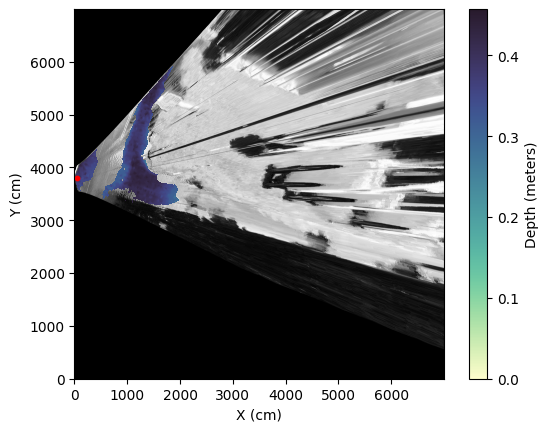

In [226]:
# Plot the image
plt.imshow(grayscale_image, cmap='gray')  # Assuming ir_array is your grayscale image

# Overlay the depth map
im = plt.imshow(depth_map, cmap=cmocean.cm.deep)  # Adjust alpha for transparency
plt.scatter(50, 3800, c='red', s=10, marker='o')

# Add a colorbar for the depth map
cbar = plt.colorbar(im, label='Depth')
cbar.set_label('Depth (meters)')

plt.gca().invert_yaxis()
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')

# Save the figure
plt.savefig('rectified_image_with_depth.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

# Show the plot
plt.show()

## Time Series and Depth Plots

In [171]:
from photo_utils import *
from datetime import datetime
from utils import *

In [1]:
from my_secrets import API_USERNAME, API_PASSWORD

authorization = (API_USERNAME, API_PASSWORD)

In [225]:
# Choose sensor location e.g. 'Beaufort', 'Carolina Beach', 'Down East', 'New Bern'
# Or provide sensor ID e.g. ['CB_01', 'DE_02']
# location = ['CB_03']
location = 'Carolina Beach'

# Set the beginning and ending dates to pull data (YYYY, MM, DD)
total_min_date = datetime(2023, 10, 1)
total_max_date = datetime(2023, 10, 3)

In [226]:
sunnyd_data = get_sunnyd_data(authorization, location, total_min_date, total_max_date)

Here is your data, human. Sincerely, 🤖


In [8]:
sunnyd_data.to_csv('sunny_day_10022023_data.csv')

In [228]:
sunnyd_data = pd.read_csv('sunny_day_10022023_data.csv')

In [230]:
image_list = os.listdir('/Users/ryan/Documents/image_processing/rectifications/CB_10_02_2023/CB_10022023_images')
image_list = sorted(image_list)
image_list[0]

'CAM_CB_03_20231002140025.jpg'

In [231]:
# Convert utc_time column to datetime
sunnyd_data['date'] = pd.to_datetime(sunnyd_data['date'])

In [232]:
# List to store the results
results = []

# Iterate over image filenames
for filename in image_list:
    # Extract the sensor id and timestamp
    sensor_id = extract_sensor_name(filename)[4:]
    timestamp = extract_timestamp(filename)

    timestamp = pytz.utc.localize(datetime.strptime(timestamp, "%Y%m%d%H%M%S"))
    
    # Filter the dataframe by sensor id
    filtered_df = sunnyd_data[sunnyd_data['sensor_ID'] == sensor_id]
    
    # Find the closest timestamp
    closest_row = filtered_df.iloc[(filtered_df['date'] - timestamp).abs().argsort()[:1]]
    
    # Append the result
    if not closest_row.empty:
        result = {
            'image_filename': filename,
            'closest_utc_time': closest_row['date'].values[0],
            'water_level': closest_row['road_water_level_adj'].values[0] * 0.3048,
            'sensor_water_level': (closest_row['sensor_water_level_adj'].values[0] - 3.05) * 0.3048
        }
        results.append(result)

# Convert the results to a dataframe
results_df = pd.DataFrame(results)

# Save the results to a CSV
# results_df.to_csv('matched_image_data.csv', index=False)

In [233]:
results_df.head()

,image_filename,closest_utc_time,water_level,sensor_water_level
0,CAM_CB_03_20231002140025.jpg,2023-10-02 14:01:13,-0.185329,-0.185329
1,CAM_CB_03_20231002140625.jpg,2023-10-02 14:07:13,-0.171182,-0.171182
2,CAM_CB_03_20231002141225.jpg,2023-10-02 14:13:13,-0.160272,-0.160272
3,CAM_CB_03_20231002141825.jpg,2023-10-02 14:19:13,-0.152867,-0.152867
4,CAM_CB_03_20231002142425.jpg,2023-10-02 14:25:13,-0.148586,-0.148586


In [299]:
plt.plot(results_df['closest_utc_time'], results_df['water_level'])
# plt.plot(results_df['closest_utc_time'], np.ones(results_df['closest_utc_time'].shape)*(3.05*0.3048), c='r', linestyle='--')

plt.xlabel('Time')
plt.xticks(rotation=45)

plt.ylabel('Water Level Relative to Roadway')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))  # Adjust format as needed

# Show the plot
plt.show()

In [298]:
virtual_sensor_locs = [[1250, 3900],
                       [750, 4400],
                       [50, 3700],
                       [86, 3547]]

In [300]:
# Open the Zarr store in read mode
store = zarr.open_group(zarr_store_path, mode='r')

pattern = re.compile(r'(?P<cam_id>CAM_[A-Z]{2}_\d{2})_(?P<timestamp>\d{14})_rectified')

max_depth_list = []
timestamp_list = []
avg_depth_list = []
vs_1_depth_list = []
vs_2_depth_list = []
vs_3_depth_list = []
vs_4_depth_list = []


for array_name in store.keys():
    match = pattern.match(array_name)
    if match:
        cam_id = match.group('cam_id')
        timestamp = match.group('timestamp')
            
        # Load the rectified image array
        # rectified_image = store[f"{cam_id}_{timestamp}_rectified"]
        # grayscale_image = np.dot(rectified_image[...,:3], [0.2989, 0.5870, 0.1140])
            
        # Load the depth map array
        depth_map_name = f"{cam_id}_{timestamp}_predseg_labels_rectified_depth_map_median_edge_rectified"
        depth_map = store[depth_map_name]

        max_elev_point_indices = np.unravel_index(np.nanargmin(depth_map), depth_map.shape)
        
        max_depth = np.nanmax(depth_map)
        avg_depth = np.nanmean(depth_map)

        vs_1_depth = depth_map[virtual_sensor_locs[0][1], virtual_sensor_locs[0][0]]
        vs_2_depth = depth_map[virtual_sensor_locs[1][1], virtual_sensor_locs[1][0]]
        vs_3_depth = depth_map[virtual_sensor_locs[2][1], virtual_sensor_locs[2][0]]
        vs_4_depth = depth_map[virtual_sensor_locs[3][1], virtual_sensor_locs[3][0]]

        timestamp_list.append(timestamp)
        max_depth_list.append(max_depth)
        avg_depth_list.append(avg_depth)
        vs_1_depth_list.append(vs_1_depth)
        vs_2_depth_list.append(vs_2_depth)
        vs_3_depth_list.append(vs_3_depth)
        vs_4_depth_list.append(vs_3_depth)





In [301]:
datetimes = pd.to_datetime(timestamp_list)

In [302]:
water_level_color = cmocean.cm.balance(0.2)
# roadway_elevation_color = cmocean.cm.deep(0.7)
max_depth_color = cmocean.cm.balance(0.9)
avg_depth_color = cmocean.cm.balance(0.6)
sensor_1_color = cmocean.cm.phase(0.1)
sensor_2_color = cmocean.cm.phase(0.3)
sensor_3_color = cmocean.cm.phase(0.5)

In [303]:
date_obj = datetime.strptime('20231002150626', '%Y%m%d%H%M%S')

In [60]:
0.25/0.3048 * 12

9.842519685039369

In [61]:
0.1/0.3048 * 12

3.937007874015748

In [304]:
# Plotting the observed water level and roadway elevation

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, sharey=True)
fig, ax1 = plt.subplots(1, 1, figsize=(12, 10), sharex=True, sharey=True)


# Plotting the max and average depth
# ax1.plot(datetimes, max_depth_list, label='Maximum Depth', linestyle='-', color=max_depth_color)
# ax1.plot(datetimes, avg_depth_list, label='Average Depth', linestyle='-.', color=avg_depth_color)
ax1.plot(results_df['closest_utc_time'], results_df['water_level'], label='Observed Water Level', color=water_level_color)
# ax1.plot(results_df['closest_utc_time'], np.zeros(results_df['closest_utc_time'].shape), 
#          c='k', linestyle='--', label='Roadway Elevation')

# ax2.plot(results_df['closest_utc_time'], results_df['water_level'], label='Observed Water Level', color=water_level_color)
# ax2.plot(results_df['closest_utc_time'], np.zeros(results_df['closest_utc_time'].shape), 
#          c='k', linestyle='--', label='Roadway Elevation')

# Plotting the sensor readings

ax1.plot(datetimes, vs_4_depth_list, label='Sensor 4 Depth', marker='x', color=sensor_3_color)

# ax1.plot(datetimes, vs_3_depth_list, label='Sensor 1 Depth', marker='d', color=sensor_3_color)
ax1.scatter(datetimes, vs_3_depth_list, label='Sensor 1 Depth', marker='d', color=sensor_3_color)
# ax1.plot(datetimes, vs_1_depth_list, label='Sensor 2 Depth',  marker='v', color=sensor_1_color)
ax1.scatter(datetimes, vs_1_depth_list, label='Sensor 2 Depth',  marker='v', color=sensor_1_color)
# ax1.plot(datetimes, vs_2_depth_list, label='Sensor 3 Depth', marker='s', color=sensor_2_color)
ax1.scatter(datetimes, vs_2_depth_list, label='Sensor 3 Depth', marker='s', color=sensor_2_color)

# Axis labels and title
plt.xlabel('Time', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Water Depth (m)', fontsize=16)
# plt.ylim((0,0.6))
ax1.set_title('Depth Measurements Over Time', fontsize=18)
# ax2.set_title('Water Level From Virtual Sensor Locations Over Time')

# Adding gridlines
ax1.grid(True)
# ax2.grid(True)

ax1.axvline(x=date_obj, color='k', linestyle='-', zorder=1)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))  # Adjust format as needed
ax1.set_ylim(-0.5, 1)

# Adding legend outside of the figure bounds
# ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
ax1.legend(loc='best', fontsize=12)
# ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.savefig('water_level_obs_plot.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


In [186]:
def plot_depth_maps_with_water_lvl(zarr_store_path, grid_z, plotting_folder, virtual_sensor_locs, depth_min=None, depth_max=None):
    
    if not os.path.exists(plotting_folder):
        os.makedirs(plotting_folder)
        print(f'Directory to store grids created: {plotting_folder}')
    else:
        print(f'Directory to store grids already exists: {plotting_folder}')

    # Open the Zarr store in read mode
    store = zarr.open_group(zarr_store_path, mode='r')

    pattern = re.compile(r'(?P<cam_id>CAM_[A-Z]{2}_\d{2})_(?P<timestamp>\d{14})_rectified')

    for array_name in store.keys():
        match = pattern.match(array_name)
        if match:
            cam_id = match.group('cam_id')
            timestamp = match.group('timestamp')

            date = pd.to_datetime(timestamp)
            
            # Load the rectified image array
            rectified_image = store[f"{cam_id}_{timestamp}_rectified"]
            grayscale_image = np.dot(rectified_image[...,:3], [0.2989, 0.5870, 0.1140])
            
            # Load the depth map array
            depth_map_name = f"{cam_id}_{timestamp}_predseg_labels_rectified_depth_map_median_edge_rectified"
            depth_map = store[depth_map_name]

            # max_elev_point_indices = np.unravel_index(np.nanargmin(depth_map), depth_map.shape)

            # max_depth = np.nanmax(depth_map)
            # avg_depth = np.nanmean(depth_map)

            vs_1_depth = depth_map[virtual_sensor_locs[0][1], virtual_sensor_locs[0][0]]
            vs_2_depth = depth_map[virtual_sensor_locs[1][1], virtual_sensor_locs[1][0]]
            vs_3_depth = depth_map[virtual_sensor_locs[2][1], virtual_sensor_locs[2][0]]

            # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, sharey=True)

            fig = plt.figure(figsize=(12, 12))

            # Create a GridSpec with 3 rows and 1 column, where the first row is larger
            gs = fig.add_gridspec(3, 1, height_ratios=[3, 1, 1])

            ax1 = fig.add_subplot(gs[0])
            ax1.imshow(grayscale_image, cmap='gray')  # Assuming ir_array is your grayscale image
            im = ax1.imshow(depth_map, cmap=cmocean.cm.deep, vmin=depth_min, vmax=depth_max)  # Adjust alpha for transparency
            ax1.scatter(virtual_sensor_locs[0][0], virtual_sensor_locs[0][1], color=sensor_1_color, s=15, marker='v')
            ax1.scatter(virtual_sensor_locs[1][0], virtual_sensor_locs[1][1], color=sensor_2_color, s=15, marker='s')
            ax1.scatter(virtual_sensor_locs[2][0], virtual_sensor_locs[2][1], color=sensor_3_color, s=15, marker='d')
            cbar = plt.colorbar(im, label='Depth')
            cbar.set_label('Depth (m)')
            ax1.invert_yaxis()
            ax1.set_xlabel('X (cm)')
            ax1.set_ylabel('Y (cm)')

            ax1.text(0.05, 0.95, f'Spatial Extent ($m^2$): {round((np.sum(~np.isnan(depth_map))) * 0.0001, 2)}', 
                     transform=ax1.transAxes, 
                     fontsize=12, 
                     verticalalignment='top', 
                     bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

            ax2 = fig.add_subplot(gs[1])
            ax2.plot(results_df['closest_utc_time'], results_df['water_level'], label='Observed Water Level', color=water_level_color)
            ax2.plot(results_df['closest_utc_time'], np.zeros(results_df['closest_utc_time'].shape), 
                     c='k', linestyle='--', label='Roadway Elevation')

            # Plotting the max and average depth
            ax2.plot(datetimes, max_depth_list, label='Maximum Depth', linestyle='-', color=max_depth_color)
            ax2.plot(datetimes, avg_depth_list, label='Average Depth', linestyle='-.', color=avg_depth_color)
            ax2.axvline(x=date, color='k', linestyle='-')

            ax3 = fig.add_subplot(gs[2], sharex=ax2, sharey=ax2)
            ax3.plot(results_df['closest_utc_time'], results_df['water_level'], label='Observed Water Level', color=water_level_color)
            ax3.plot(results_df['closest_utc_time'], np.zeros(results_df['closest_utc_time'].shape), 
                     c='k', linestyle='--', label='Roadway Elevation')

            # Plotting the sensor readings
            ax3.scatter(datetimes, vs_1_depth_list, label='Sensor 1 Depth',  marker='v', color=sensor_1_color, s=5)
            ax3.scatter(datetimes, vs_2_depth_list, label='Sensor 2 Depth', marker='s', color=sensor_2_color, s=5)
            ax3.scatter(datetimes, vs_3_depth_list, label='Sensor 3 Depth', marker='d', color=sensor_3_color, s=5)
            
            ax3.axvline(x=date, color='k', linestyle='-', zorder=1)
            ax3.scatter(date, vs_1_depth, marker='v', color=sensor_1_color, s=20, zorder=2)
            ax3.scatter(date, vs_2_depth, marker='s', color=sensor_2_color, s=20, zorder=2)
            ax3.scatter(date, vs_3_depth, marker='d', color=sensor_3_color, s=20, zorder=2)
            ax2.set_ylim(-0.25,0.75)
            ax3.set_ylim(-0.25,0.75)

            # Axis labels and title
            ax2.set_xlabel('Time')
            ax2.tick_params(axis='x', rotation=45)
            ax3.tick_params(axis='x', rotation=45)
            # ax3.set_xticklabels(ax3.get_xticks(), rotation=45)
            ax2.set_ylabel('Water Level Relative to Roadway (m)')
            ax2.set_title('Water Level and Depth Measurements Over Time')
            ax3.set_title('Water Level From Virtual Sensor Locations Over Time')

            # Adding gridlines
            ax2.grid(True)
            ax3.grid(True)

            ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))  # Adjust format as needed

            # Adding legend outside of the figure bounds
            ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
            ax3.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
            

            plt.tight_layout()
            
            # Save the figure
            plt.savefig(os.path.join(plotting_folder, f'{cam_id}_{timestamp}_depth_map_w_water_level.png'), 
                        bbox_inches='tight', pad_inches=0.1, dpi=300)
            
            plt.close()

    return None

In [187]:
plotting_folder = 'depth_maps_w_water_levels_median_edge'
plot_depth_maps_with_water_lvl(zarr_store_path, grid_z, plotting_folder, virtual_sensor_locs, 0, 0.5)

Directory to store grids created: depth_maps_w_water_levels_median_edge


In [330]:
depth_map.shape

(7000, 7000)

In [333]:
count_not_nan = (np.sum(~np.isnan(depth_map))) * 0.0001

In [334]:
count_not_nan

81.1464

## Edge Point Elevations

In [190]:
def calculate_edge_point_elevs(zarr_store_path, grid_z, method=None):
    
    # if method is None:
    #     return print("Please specify a method of extracting elevation values.")

    edge_elevations = []
    
    # Open the Zarr store in read mode
    store = zarr.open_group(zarr_store_path, mode='r')

    # Iterate through all arrays in the store
    for array_name in store:
        # Check if 'labels' is in the array's name
        if 'labels' in array_name and 'depth' not in array_name:
            # Load the specific array
            array = store[array_name][:]
            # print(array_name)

            labels_squeezed = array.squeeze()

            mask = (labels_squeezed == 1)
            masked_elevations = np.where(mask, grid_z, np.nan)

            # Step 1: Replace NaNs with a value that will not interfere with contour detection
            arr_with_zeros = np.nan_to_num(masked_elevations, nan=0)

            # Step 2: Detect contours
            contours = find_contours(arr_with_zeros, level=0.5)
            # print(len(contours))

            # Step 3: Convert contour coordinates to integer indices
            contour_pixels = []
            for contour in contours:
                for point in contour:
                    y, x = np.round(point).astype(int)
                    if 0 <= x < masked_elevations.shape[1] and 0 <= y < masked_elevations.shape[0]:  # Ensure indices are within bounds
                        contour_pixels.append((x, y))

            # Convert list to NumPy array for easier manipulation
            contour_pixels = np.array(contour_pixels)

            # Create a mask to identify valid pixels
            valid_mask = ~np.isnan(masked_elevations)

            # Get the coordinates of valid pixels
            valid_coords = np.array(np.nonzero(valid_mask)).T

            # Get the values at valid coordinates
            valid_values = masked_elevations[valid_mask]

            # Build a KD-tree from valid coordinates
            tree = cKDTree(valid_coords)

            # Find the nearest valid pixel for each contour pixel
            distances, indices = tree.query(contour_pixels)

            # Get the corresponding values
            contour_values = valid_values[indices]
            # max_elevation = np.nanmedian(contour_values)
            # depth_map = masked_elevations - max_elevation
            # depth_map[depth_map > 0] = 0
            # depth_map = np.abs(depth_map)


            # Append the image name and ir array to the list
            edge_elevations.append({'image_name': array_name + '_edge_elevations', 'depth_map': contour_values})

    results = pd.DataFrame(edge_elevations)

    return results

In [191]:
edge_df = calculate_edge_point_elevs(zarr_store_path, grid_z)

In [192]:
edge_df.head()

,image_name,depth_map
0,CAM_CB_03_20231002140025_predseg_labels_rectif...,"[1.4165553360813712, 1.4165553360813712, 1.416..."
1,CAM_CB_03_20231002140625_predseg_labels_rectif...,"[0.9901257444430244, 0.9901257444430244, 0.990..."
2,CAM_CB_03_20231002141225_predseg_labels_rectif...,"[1.0911307642481272, 1.0911307642481272, 1.091..."
3,CAM_CB_03_20231002141825_predseg_labels_rectif...,"[0.8676741980896303, 0.8676741980896303, 0.867..."
4,CAM_CB_03_20231002142425_predseg_labels_rectif...,"[0.8738025568811644, 0.8738025568811644, 0.873..."


In [195]:
edge_df['depth_map'][0].shape

(26208,)

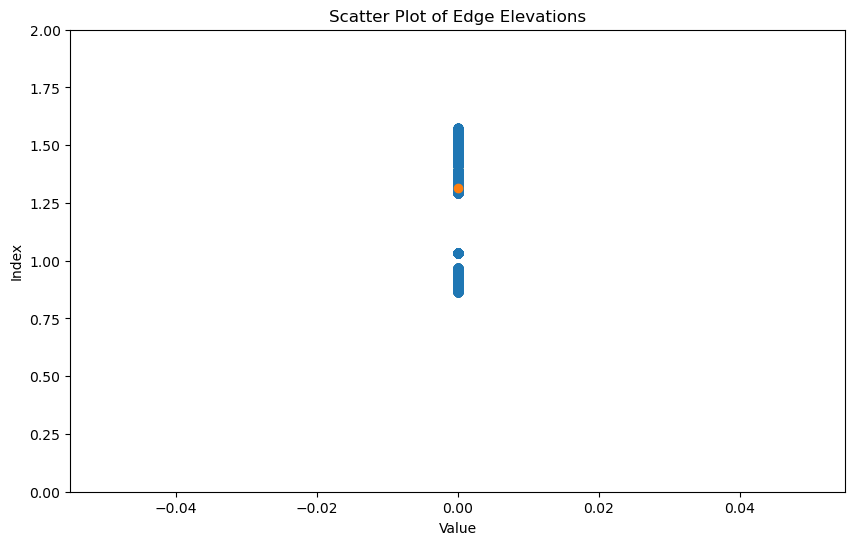

In [218]:
plt.figure(figsize=(10, 6))
plt.scatter(np.zeros(edge_df['depth_map'][0].shape), edge_df['depth_map'][0], alpha=0.7)
plt.scatter(0, np.nanmedian(edge_df['depth_map'][0]))
plt.ylim((0,2))
plt.xlabel('Value')
plt.ylabel('Index')
plt.title('Scatter Plot of Edge Elevations')
plt.show()

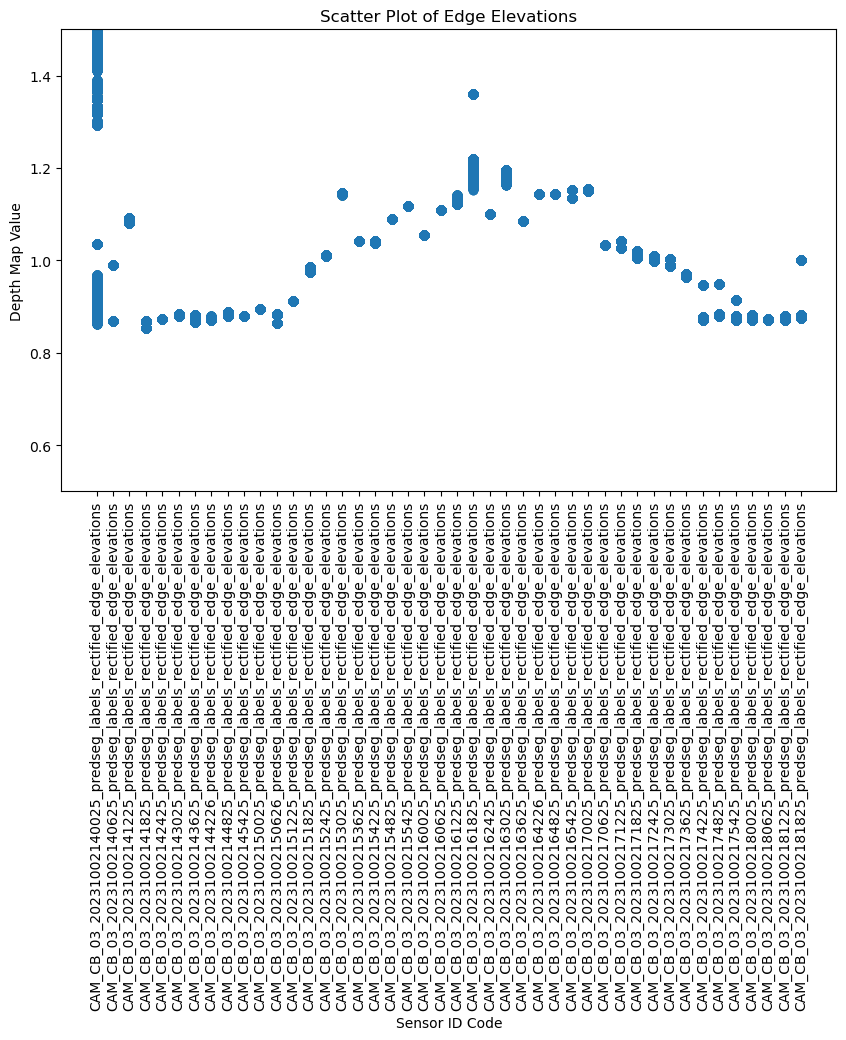

In [219]:
plt.figure(figsize=(10, 6))

# Extract unique sensor IDs and map them to numerical codes
sensor_ids = edge_df['image_name'].unique()
sensor_id_to_code = {sensor_id: idx for idx, sensor_id in enumerate(sensor_ids)}

# Prepare lists to store x and y values
x_values = []
y_values = []

for row in range(len(edge_df)):
    sensor_id = edge_df['image_name'][row]
    x_code = sensor_id_to_code[sensor_id]  # Get the numerical code for the sensor ID
    x_values.extend([x_code] * len(edge_df['depth_map'][row]))
    y_values.extend(edge_df['depth_map'][row])

plt.scatter(x_values, y_values, alpha=0.7)

# Optional: Add a legend to identify sensor IDs (could be omitted if too cluttered)
# plt.legend(title='Sensor ID', loc='best')

plt.ylim((0.5, 1.5))
plt.xlabel('Sensor ID Code')
plt.ylabel('Depth Map Value')
plt.title('Scatter Plot of Edge Elevations')
plt.xticks(ticks=list(sensor_id_to_code.values()), labels=list(sensor_id_to_code.keys()), rotation=90)
plt.show()
